<a href="https://colab.research.google.com/github/ifarady/attention-in-seismic/blob/main/BiSeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import Necessary Libraries
import os
import time
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
import torchvision.transforms as T
import matplotlib.cm as cm
from tqdm import tqdm

In [ ]:
# Step 2: Define Utility Functions
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
#Set Device and Model Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_path = 'bisenet_model.pth'


cuda


In [ ]:
#Specify Paths and Configuration

image_path = "competition_data/train/images"
mask_path = "competition_data/train/masks"
val_image_path = "competition_data/val/images"
val_mask_path = "competition_data/val/masks"

In [ ]:
#Load and Preprocess Data for Visualization
names = ['4c4556fff0','4c8132dc73','4c36178b41']
images = [Image.open(os.path.join(image_path, name+'.png')) for name in names]
masks = [Image.open(os.path.join(mask_path, name+'.png')) for name in names]

transforms = T.Compose([T.Grayscale(), T.ToTensor()])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

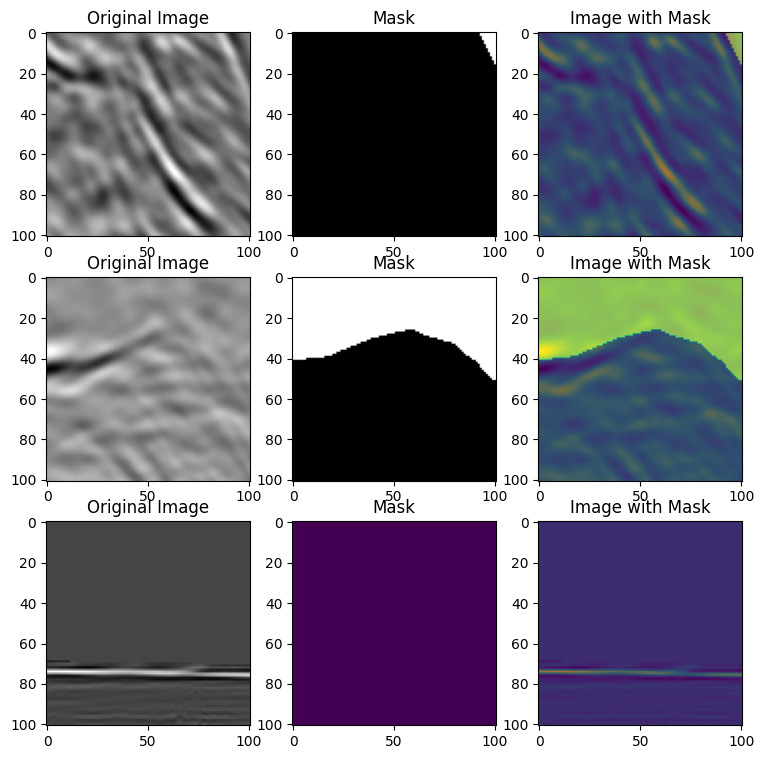

In [ ]:
# Step 6: Visualize Sample Data
fig = plt.figure(figsize=(9, 9))
num_images = len(images)
for i in range(num_images):
    ax = fig.add_subplot(num_images, 3, i*3+1)
    ax.imshow(images[i])
    ax.set_title("Original Image")

    ax = fig.add_subplot(num_images, 3, i*3+2)
    ax.imshow(masks[i])
    ax.set_title("Mask")

    ax = fig.add_subplot(num_images, 3, i*3+3)
    ax.imshow(x[i].squeeze())
    ax.imshow(y[i].squeeze(), alpha=0.5)
    ax.set_title("Image with Mask")

plt.show()

In [ ]:
# Step 7: Define Custom Dataset Class
class SegmentDataset(Dataset):

    color_encoding = [
        ('salt', (0, 0, 0)),
    ]

    def __init__(self, image_path, mask_path, num_classes=2):
        self.image_path = image_path
        self.mask_path = mask_path
        self.num_classes=num_classes

        image_list = glob.glob(image_path + '/*.png')
        sample_names = [file.split('/')[-1].split('.')[0] for file in image_list]
        self.sample_names = sample_names
#         self.transforms = T.Compose([T.Grayscale(), T.ToTensor()])
        self.transforms = T.Compose([T.ToTensor()])

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_path, self.sample_names[idx] + '.png'))
        image = image.convert('RGB')

        image = self.transforms(image)
        resized_image = T.Resize((104, 104))(image)

        mask = Image.open(os.path.join(self.mask_path, self.sample_names[idx] + '.png'))
        mask = mask.convert('RGB')
        mask = np.array(mask)
        mask = self.label_for_cross_entropy(mask)
        mask = Image.fromarray(mask)
        resized_mask = T.Resize((104, 104))(mask)
        resized_mask = np.array(resized_mask)

        return resized_image, torch.from_numpy(resized_mask).long()

    def label_for_cross_entropy(self, label):
        """
            Convert label image to matrix classes for apply cross entropy loss.
            Return semantic index, label in enumemap of H x W x class
        """
        semantic_map = np.zeros(label.shape[:-1])
        # Fill all value with class 13 - default for all pixels
        semantic_map.fill(self.num_classes - 1)
        # Fill the pixel with correct class

        for class_index, color_info in enumerate(self.color_encoding):
            color = color_info[1]
            equality = np.equal(label, color)
            class_map = np.all(equality, axis=-1)
            semantic_map[class_map] = class_index
        return semantic_map

    def __len__(self):
        return len(self.sample_names)

In [ ]:
# Step 8: Initialize Dataset
train_dataset = SegmentDataset(image_path, mask_path)
# Step 5: Validation Dataset
val_dataset = SegmentDataset(val_image_path, val_mask_path)


In [ ]:
# Step 6: Validation DataLoader
BATCH_SIZE = 64
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
image = Image.open('./competition_data/train/images/04cd9599a3.png')
rgb_image = image.convert('RGB')
print(np.asarray(rgb_image).shape)

(101, 101, 3)


In [ ]:
image, mask = train_dataset[15]
print(np.where(mask == 1)[0])
print(mask.shape)

[  0   0   0 ... 103 103 103]
torch.Size([104, 104])


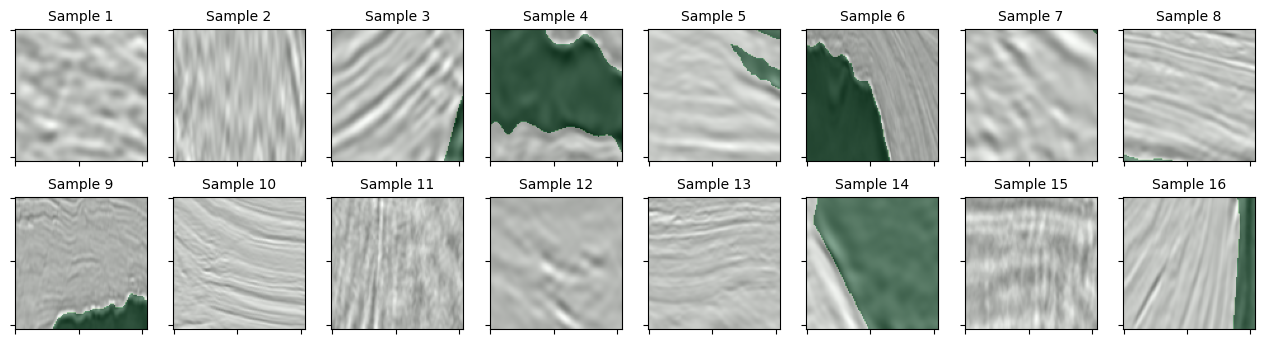

In [ ]:

# Step 9: Visualize More Data from Dataset
max_images = 16
grid_width = 8
grid_height = max_images // grid_width
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))

for i in range(max_images):
    image, mask = train_dataset[i]
    image = np.transpose(image, (1, 2, 0))
    ax = axs[i // grid_width, i % grid_width]
    ax.imshow(image.squeeze(), cmap="Greys")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Greens")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f"Sample {i+1}", fontsize=10)

# # Add color bar to indicate mask colors
# cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
# cbar = plt.colorbar(cm.ScalarMappable(cmap='Greens'), cax=cax)
# cbar.set_label('Mask Colors')

plt.show()

In [ ]:
# Step 10: Define Model Architecture
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )

        self.batch_norm = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        return self.relu(x)

"""
Defines ChannelAttention class
"""
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_rate=16):
        super(ChannelAttention, self).__init__()
        self.squeeze = nn.ModuleList([
            nn.AdaptiveAvgPool2d(1),
            nn.AdaptiveMaxPool2d(1)
        ])

        self.excitation = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=channels // reduction_rate,
                      kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels // reduction_rate,
                      out_channels=channels,
                      kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # perform squeeze with independent Pooling
        avg_feat = self.squeeze[0](x)
        max_feat = self.squeeze[1](x)
        # perform excitation with the same excitation sub-net
        avg_out = self.excitation(avg_feat)
        max_out = self.excitation(max_feat)
        # attention
        attention = self.sigmoid(avg_out + max_out)
        return attention * x

class SpatialPath(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvBlock(in_channels=3, out_channels=64)
        self.conv2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

# class SpatialPath(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = ConvBlock(in_channels=3, out_channels=64)
#         self.attention1 = ChannelAttention(64)
#         self.conv2 = ConvBlock(in_channels=64, out_channels=128)
#         self.attention2 = ChannelAttention(128)
#         self.conv3 = ConvBlock(in_channels=128, out_channels=256)
# #         self.attention3 = ChannelAttention(256)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.attention1(x)
#         x = self.conv2(x)
#         x = self.attention2(x)
#         x = self.conv3(x)
# #         x = self.attention3(x)
#         return x

class ContextPath(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features=models.resnet18(pretrained=pretrained)
        self.conv1=self.features.conv1
        self.bn1=self.features.bn1
        self.relu=self.features.relu
        self.max_pool=self.features.maxpool
        self.layer1=self.features.layer1
        self.layer2=self.features.layer2
        self.layer3=self.features.layer3
        self.layer4=self.features.layer4
        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        feature1 = self.layer1(x)
        feature2 = self.layer2(feature1)
        feature3 = self.layer3(feature2)
        feature4 = self.layer4(feature3)

        tail = self.avg_pool(feature4)
        return feature3, feature4, tail

class AttentionRefinementModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.conv=nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        self.bn=nn.BatchNorm2d(out_channels)
        self.sigmoid=nn.Sigmoid()
        self.in_channels=in_channels

    def forward(self, x_input):
        x = self.avg_pool(x_input)
        assert x.size(1) == self.in_channels,  'in_channels and out_channels should all be {}'.format(x.size(1))

        x = self.conv(x)
        x = self.bn(x)
        x = self.sigmoid(x)

        # Channel of x_input and x must be same
        return torch.mul(x_input, x)

class FeatureFusionModule(nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        self.in_channels=in_channels
        self.conv_block=ConvBlock(in_channels=in_channels, out_channels=num_classes, stride=1)
        self.conv1=nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.relu=nn.ReLU()
        self.conv2=nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.sigmoid=nn.Sigmoid()
        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))

    def forward(self, x_input_1, x_input_2):
        x = torch.cat((x_input_1, x_input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.conv_block(x)

        # Apply above branch in feature
        x = self.avg_pool(feature)
        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))

        # Multipy feature and x
        x = torch.mul(feature, x)

        # Combine feature and x
        return torch.add(feature, x)

In [ ]:
# Step 11: Define BiSeNet Model
class BiSeNet(nn.Module):
    def __init__(self, num_classes, training=True):
        super().__init__()
        self.training = training
        self.spatial_path = SpatialPath()
        self.context_path = ContextPath()
        self.arm1 = AttentionRefinementModule(in_channels=256, out_channels=256)
        self.arm2 = AttentionRefinementModule(in_channels=512, out_channels=512)

        # Supervision for calculate loss
        self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
        self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)

        # Feature fusion module
        self.ffm = FeatureFusionModule(num_classes=num_classes, in_channels=1024)

        # Final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

    def forward(self, x_input):
        # Spatial path output
        sp_out = self.spatial_path(x_input)

        # Context path output
        feature1, feature2, tail = self.context_path(x_input)

        # apply attention refinement module
        feature1, feature2 = self.arm1(feature1), self.arm2(feature2)

        # Combine output of lightweight model with tail
        feature2 = torch.mul(feature2, tail)

        # Up sampling
        size2d_out = sp_out.size()[-2:]
        feature1 = F.interpolate(feature1, size=size2d_out, mode='bilinear')
        feature2 = F.interpolate(feature2, size=size2d_out, mode='bilinear')
        context_out = torch.cat((feature1, feature2), dim=1)

        # Apply Feature Fusion Module
        combine_feature = self.ffm(sp_out, context_out)

        # Up sampling
        bisenet_out = F.interpolate(combine_feature, scale_factor=8, mode='bilinear')
        bisenet_out = self.conv(bisenet_out)

        # When training model
        if True:
            feature1_sup = self.supervision1(feature1)
            feature2_sup = self.supervision2(feature2)
            feature1_sup = F.interpolate(feature1_sup, size=x_input.size()[-2:], mode='bilinear')
            feature2_sup = F.interpolate(feature2_sup, size=x_input.size()[-2:], mode='bilinear')
            return bisenet_out, feature1_sup, feature2_sup
        return bisenet_out

In [ ]:
# Step 14.1: Define Helper Functions

def reverse_one_hot(image):
    # Convert output of model to predicted class
    image = image.permute(0, 2, 3, 1)
    x = torch.argmax(image, dim=-1)
    return x

def compute_accuracy(pred, label):
    pred = pred.flatten()
    label = label.flatten()
    total = len(label)
    count = 0.0
    for i in range(total):
        if pred[i] == label[i]:
            count = count + 1.0
    return float(count) / float(total)

In [ ]:
# Step 14.2: Get IoU Score
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

def per_class_iu(hist):
    epsilon = 1e-5
    return (np.diag(hist) + epsilon) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

In [ ]:
# Step 15: Get validate function
NUM_CLASSES=2
def val(model, dataloader):
    accuracy_arr = []

    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))

    with torch.no_grad():
        model.eval()
        print('Starting validate')

        val_loss_record = []

        for i, (val_data, val_label) in enumerate(dataloader):
            val_data = val_data.cuda()
            val_label_cuda = val_label.cuda()
            # The output of model is (1, num_classes, W, H) => (num_classes, W, H)
            val_output, val_output_sup1, val_output_sup2 = model(val_data)

            val_loss1 = loss_func(val_output, val_label_cuda)
            val_loss2 = loss_func(val_output_sup1, val_label_cuda)
            val_loss3 = loss_func(val_output_sup2, val_label_cuda)

            # Combine 3 loss
            val_loss = val_loss1 + val_loss2 + val_loss3

            val_output = val_output.squeeze()
            val_output_sup1 = val_output_sup1.squeeze()
            val_output_sup2 = val_output_sup1.squeeze()
            # Convert the (num_classes, W, H) => (W, H) with one hot decoder
            val_output = reverse_one_hot(val_output)
            val_output = np.array(val_output.cpu())
            # Process label. Convert to (W, H) image
            val_label = val_label.squeeze()
            val_label = np.array(val_label.cpu())
            # Compute accuracy and iou
            accuracy = compute_accuracy(val_output, val_label)
            hist += fast_hist(val_label.flatten(), val_output.flatten(), NUM_CLASSES)
            # Append for calculate
            accuracy_arr.append(accuracy)
            val_loss_record.append(loss.item())

        val_loss_mean = np.mean(val_loss_record)
        miou_list = per_class_iu(hist)[:-1]
        mean_accuracy, mean_iou = np.mean(accuracy_arr), np.mean(miou_list)
        print('Mean validate loss: {} Mean validate IoU: {}'.format(val_loss_mean, mean_iou))
        return mean_accuracy, mean_iou, val_loss_mean

In [ ]:
# Step 16.1: Create DataLoader for Training Dataset
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
steps = len(train_dataset) // BATCH_SIZE
print(steps, "steps per epoch")


56 steps per epoch


In [ ]:
# Step 16.3: Define model and training function, hyperparameters
EPOCHS = 200
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
CHECKPOINT_STEP = 2
VALIDATE_STEP = 1

model = BiSeNet(num_classes=NUM_CLASSES, training=True).to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

loss_func = torch.nn.CrossEntropyLoss()

In [ ]:
# Step 16.2: Model Training

# Loop for training
torch.cuda.empty_cache()

max_miou = 0
max_miou_epoch = 0

train_iou_hist = []
val_iou_hist = []

train_loss_hist = []
val_loss_hist = []

for epoch in range(EPOCHS):
    model.train()
    tq = tqdm(total=len(dataloader_train) * BATCH_SIZE)
    tq.set_description('Epoch {}/{}'.format(epoch + 1, EPOCHS))

    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))
    loss_record = []

    for i, (data, label) in enumerate(dataloader_train):
        data = data.cuda()
        label = label.cuda()
        output, output_sup1, output_sup2 = model(data)
        loss1 = loss_func(output, label)
        loss2 = loss_func(output_sup1, label)
        loss3 = loss_func(output_sup2, label)

        # Combine 3 loss
        loss = loss1 + loss2 + loss3
        tq.update(BATCH_SIZE)
        tq.set_postfix(loss='%.6f' % loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_record.append(loss.item())

        output = reverse_one_hot(output)
        output = np.array(output.cpu())

        hist += fast_hist(label.flatten().detach().cpu().numpy(), output.flatten(), NUM_CLASSES)

    tq.close()
    loss_train_mean = np.mean(loss_record)
    miou_list = per_class_iu(hist)[:-1]
    mean_iou = np.mean(miou_list)

    train_iou_hist = train_iou_hist + [mean_iou]
    train_loss_hist = train_loss_hist + [loss_train_mean]

    print('loss for train : %f' % (loss_train_mean))
    print('IoU for train : %f' % (mean_iou))

    # Save checkpoint
    if epoch % CHECKPOINT_STEP == 0:
        torch.save(model.state_dict(), 'lastest_model.pth')

    # Validate save best model
    # Save checkpoint
    if epoch % VALIDATE_STEP == 0:
        _, mean_iou, val_loss = val(model, dataloader_val)
        val_iou_hist = val_iou_hist + [mean_iou]
        val_loss_hist = val_loss_hist + [val_loss]
        if mean_iou > max_miou:
            max_miou = mean_iou
            max_miou_epoch = epoch
            print('Save best model with mIoU = {}'.format(mean_iou))
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            print('Best mIoU: {} at epoch {}'.format(max_miou, max_miou_epoch))

Epoch 1/200:   0%|                                                                                 | 0/3584 [00:00<?, ?it/s]/home/sang/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
Epoch 1/200: 100%|██████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.30it/s, loss=1.148499]


loss for train : 1.385013
IoU for train : 0.820690
Starting validate
Mean validate loss: 1.1484994888305664 Mean validate IoU: 0.8584873148738421
Save best model with mIoU = 0.8584873148738421


Epoch 2/200: 100%|██████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 436.96it/s, loss=0.815103]


loss for train : 0.919301
IoU for train : 0.887442
Starting validate
Mean validate loss: 0.8151032328605652 Mean validate IoU: 0.8885416474007697
Save best model with mIoU = 0.8885416474007697


Epoch 3/200: 100%|██████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 430.49it/s, loss=0.851105]


loss for train : 0.783928
IoU for train : 0.905622
Starting validate
Mean validate loss: 0.8511049151420593 Mean validate IoU: 0.9105413833137631
Save best model with mIoU = 0.9105413833137631


Epoch 4/200: 100%|██████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 427.56it/s, loss=0.630682]


loss for train : 0.690513
IoU for train : 0.920309
Starting validate
Mean validate loss: 0.6306820511817932 Mean validate IoU: 0.9142823075763485
Save best model with mIoU = 0.9142823075763485


Epoch 5/200: 100%|██████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 434.63it/s, loss=0.596971]


loss for train : 0.615426
IoU for train : 0.929446
Starting validate
Mean validate loss: 0.5969709753990173 Mean validate IoU: 0.9060621669671234
Best mIoU: 0.9142823075763485 at epoch 3


Epoch 6/200: 100%|██████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 421.54it/s, loss=0.480024]


loss for train : 0.566715
IoU for train : 0.936130
Starting validate
Mean validate loss: 0.4800240695476532 Mean validate IoU: 0.9192655685549028
Save best model with mIoU = 0.9192655685549028


Epoch 7/200: 100%|██████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 426.72it/s, loss=0.693363]


loss for train : 0.513442
IoU for train : 0.944705
Starting validate
Mean validate loss: 0.6933627128601074 Mean validate IoU: 0.8972096373963284
Best mIoU: 0.9192655685549028 at epoch 5


Epoch 8/200: 100%|██████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.40it/s, loss=0.422528]


loss for train : 0.464774
IoU for train : 0.951403
Starting validate
Mean validate loss: 0.4225284457206726 Mean validate IoU: 0.9171830565069254
Best mIoU: 0.9192655685549028 at epoch 5


Epoch 9/200: 100%|██████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 430.61it/s, loss=0.543861]


loss for train : 0.449006
IoU for train : 0.950244
Starting validate
Mean validate loss: 0.543861448764801 Mean validate IoU: 0.8968626611700871
Best mIoU: 0.9192655685549028 at epoch 5


Epoch 10/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 438.36it/s, loss=0.670623]


loss for train : 0.447284
IoU for train : 0.949210
Starting validate
Mean validate loss: 0.6706226468086243 Mean validate IoU: 0.9120287517351977
Best mIoU: 0.9192655685549028 at epoch 5


Epoch 11/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 436.34it/s, loss=0.327121]


loss for train : 0.381061
IoU for train : 0.958981
Starting validate
Mean validate loss: 0.32712098956108093 Mean validate IoU: 0.90863158646317
Best mIoU: 0.9192655685549028 at epoch 5


Epoch 12/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 429.84it/s, loss=0.347677]


loss for train : 0.350994
IoU for train : 0.963475
Starting validate
Mean validate loss: 0.34767669439315796 Mean validate IoU: 0.9287684382674812
Save best model with mIoU = 0.9287684382674812


Epoch 13/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 430.29it/s, loss=0.397232]


loss for train : 0.318193
IoU for train : 0.966830
Starting validate
Mean validate loss: 0.397232323884964 Mean validate IoU: 0.9340564590799171
Save best model with mIoU = 0.9340564590799171


Epoch 14/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 429.52it/s, loss=0.293865]


loss for train : 0.271736
IoU for train : 0.974182
Starting validate
Mean validate loss: 0.293865442276001 Mean validate IoU: 0.9420209883609463
Save best model with mIoU = 0.9420209883609463


Epoch 15/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 432.55it/s, loss=0.243034]


loss for train : 0.250428
IoU for train : 0.976244
Starting validate
Mean validate loss: 0.24303431808948517 Mean validate IoU: 0.9213637344800248
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 16/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.91it/s, loss=0.492055]


loss for train : 0.278661
IoU for train : 0.970604
Starting validate
Mean validate loss: 0.49205535650253296 Mean validate IoU: 0.9167552311854363
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 17/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 432.26it/s, loss=0.247423]


loss for train : 0.302015
IoU for train : 0.965883
Starting validate
Mean validate loss: 0.2474229782819748 Mean validate IoU: 0.8960884835808509
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 18/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 432.50it/s, loss=0.414851]


loss for train : 0.274513
IoU for train : 0.969619
Starting validate
Mean validate loss: 0.4148513674736023 Mean validate IoU: 0.9173411950499882
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 19/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 433.49it/s, loss=0.303083]


loss for train : 0.248941
IoU for train : 0.972792
Starting validate
Mean validate loss: 0.3030829429626465 Mean validate IoU: 0.9317582205198369
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 20/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 433.64it/s, loss=0.324533]


loss for train : 0.285602
IoU for train : 0.967018
Starting validate
Mean validate loss: 0.32453298568725586 Mean validate IoU: 0.9130531181653506
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 21/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 432.04it/s, loss=0.233054]


loss for train : 0.264723
IoU for train : 0.969074
Starting validate
Mean validate loss: 0.23305359482765198 Mean validate IoU: 0.9095535587188656
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 22/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 434.93it/s, loss=0.235386]


loss for train : 0.235086
IoU for train : 0.973703
Starting validate
Mean validate loss: 0.2353857457637787 Mean validate IoU: 0.9201040688297292
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 23/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 430.69it/s, loss=0.200711]


loss for train : 0.241487
IoU for train : 0.971111
Starting validate
Mean validate loss: 0.20071108639240265 Mean validate IoU: 0.9037484124891092
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 24/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 434.05it/s, loss=0.166328]


loss for train : 0.217054
IoU for train : 0.975728
Starting validate
Mean validate loss: 0.16632770001888275 Mean validate IoU: 0.9264976200529076
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 25/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 432.52it/s, loss=0.161803]


loss for train : 0.169335
IoU for train : 0.982731
Starting validate
Mean validate loss: 0.1618029922246933 Mean validate IoU: 0.9269490684646219
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 26/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 429.36it/s, loss=0.145346]


loss for train : 0.154666
IoU for train : 0.984648
Starting validate
Mean validate loss: 0.14534565806388855 Mean validate IoU: 0.9320055390374418
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 27/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 435.98it/s, loss=0.138370]


loss for train : 0.143851
IoU for train : 0.985942
Starting validate
Mean validate loss: 0.13837020099163055 Mean validate IoU: 0.9300890174157168
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 28/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 427.30it/s, loss=0.118107]


loss for train : 0.134917
IoU for train : 0.986941
Starting validate
Mean validate loss: 0.11810733377933502 Mean validate IoU: 0.9355979652653548
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 29/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 434.52it/s, loss=0.132637]


loss for train : 0.129453
IoU for train : 0.987392
Starting validate
Mean validate loss: 0.1326366662979126 Mean validate IoU: 0.9364251271813477
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 30/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 424.47it/s, loss=0.115946]


loss for train : 0.123659
IoU for train : 0.988053
Starting validate
Mean validate loss: 0.11594578623771667 Mean validate IoU: 0.9285927952925828
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 31/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 433.56it/s, loss=0.109421]


loss for train : 0.119792
IoU for train : 0.988351
Starting validate
Mean validate loss: 0.10942062735557556 Mean validate IoU: 0.9350426653584806
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 32/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.56it/s, loss=0.108866]


loss for train : 0.115852
IoU for train : 0.988602
Starting validate
Mean validate loss: 0.10886550694704056 Mean validate IoU: 0.9355763886752231
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 33/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 430.74it/s, loss=0.103383]


loss for train : 0.110819
IoU for train : 0.989081
Starting validate
Mean validate loss: 0.10338304936885834 Mean validate IoU: 0.9386247847769909
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 34/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 430.21it/s, loss=0.106673]


loss for train : 0.107174
IoU for train : 0.989504
Starting validate
Mean validate loss: 0.10667291283607483 Mean validate IoU: 0.9380893420085192
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 35/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 436.07it/s, loss=0.093522]


loss for train : 0.103652
IoU for train : 0.989796
Starting validate
Mean validate loss: 0.09352202713489532 Mean validate IoU: 0.9364762767153204
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 36/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 432.73it/s, loss=0.108192]


loss for train : 0.101573
IoU for train : 0.989683
Starting validate
Mean validate loss: 0.10819228738546371 Mean validate IoU: 0.9372914163567357
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 37/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 428.97it/s, loss=0.104864]


loss for train : 0.100669
IoU for train : 0.989648
Starting validate
Mean validate loss: 0.10486447811126709 Mean validate IoU: 0.9356908420796398
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 38/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 435.00it/s, loss=0.107575]


loss for train : 0.097353
IoU for train : 0.989994
Starting validate
Mean validate loss: 0.107575424015522 Mean validate IoU: 0.9363488115955176
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 39/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 436.52it/s, loss=0.097799]


loss for train : 0.094223
IoU for train : 0.990368
Starting validate
Mean validate loss: 0.09779907017946243 Mean validate IoU: 0.9392554405330455
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 40/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.27it/s, loss=0.099848]


loss for train : 0.092207
IoU for train : 0.990607
Starting validate
Mean validate loss: 0.09984774887561798 Mean validate IoU: 0.9394640807147356
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 41/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 425.93it/s, loss=0.084784]


loss for train : 0.090695
IoU for train : 0.990447
Starting validate
Mean validate loss: 0.08478384464979172 Mean validate IoU: 0.9387812987964803
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 42/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 457.41it/s, loss=0.091175]


loss for train : 0.088570
IoU for train : 0.990702
Starting validate
Mean validate loss: 0.09117546677589417 Mean validate IoU: 0.9329226662681408
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 43/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 455.49it/s, loss=0.099441]


loss for train : 0.087812
IoU for train : 0.990808
Starting validate
Mean validate loss: 0.09944082796573639 Mean validate IoU: 0.933512123965601
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 44/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.04it/s, loss=0.086440]


loss for train : 0.084664
IoU for train : 0.991009
Starting validate
Mean validate loss: 0.08643954247236252 Mean validate IoU: 0.9358541190501726
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 45/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 448.04it/s, loss=0.091090]


loss for train : 0.082211
IoU for train : 0.991392
Starting validate
Mean validate loss: 0.09108990430831909 Mean validate IoU: 0.9348556616883117
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 46/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 452.88it/s, loss=0.082920]


loss for train : 0.081175
IoU for train : 0.991364
Starting validate
Mean validate loss: 0.08292011171579361 Mean validate IoU: 0.9370804689715163
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 47/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 462.76it/s, loss=0.075103]


loss for train : 0.080026
IoU for train : 0.991366
Starting validate
Mean validate loss: 0.07510307431221008 Mean validate IoU: 0.9384416850025024
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 48/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 457.49it/s, loss=0.076304]


loss for train : 0.078458
IoU for train : 0.991577
Starting validate
Mean validate loss: 0.07630421221256256 Mean validate IoU: 0.9356208510170748
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 49/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.09it/s, loss=0.079905]


loss for train : 0.076723
IoU for train : 0.991730
Starting validate
Mean validate loss: 0.07990498840808868 Mean validate IoU: 0.9376134540388537
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 50/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 460.95it/s, loss=0.093680]


loss for train : 0.076659
IoU for train : 0.991670
Starting validate
Mean validate loss: 0.09367962181568146 Mean validate IoU: 0.9346908052404229
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 51/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 456.11it/s, loss=0.073944]


loss for train : 0.075901
IoU for train : 0.991612
Starting validate
Mean validate loss: 0.07394362986087799 Mean validate IoU: 0.935384739906392
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 52/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 457.46it/s, loss=0.069640]


loss for train : 0.074034
IoU for train : 0.991870
Starting validate
Mean validate loss: 0.06964030861854553 Mean validate IoU: 0.934298825705553
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 53/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 460.36it/s, loss=0.076945]


loss for train : 0.072242
IoU for train : 0.992091
Starting validate
Mean validate loss: 0.07694460451602936 Mean validate IoU: 0.9355987106025763
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 54/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 461.34it/s, loss=0.060162]


loss for train : 0.071978
IoU for train : 0.991937
Starting validate
Mean validate loss: 0.06016169488430023 Mean validate IoU: 0.9328818797860966
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 55/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 456.53it/s, loss=0.079330]


loss for train : 0.070214
IoU for train : 0.992268
Starting validate
Mean validate loss: 0.07932998985052109 Mean validate IoU: 0.939723759809593
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 56/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 457.50it/s, loss=0.072174]


loss for train : 0.068763
IoU for train : 0.992438
Starting validate
Mean validate loss: 0.07217366248369217 Mean validate IoU: 0.9344235066697056
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 57/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.76it/s, loss=0.058632]


loss for train : 0.068453
IoU for train : 0.992450
Starting validate
Mean validate loss: 0.05863230675458908 Mean validate IoU: 0.9361052741173186
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 58/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 457.70it/s, loss=0.058815]


loss for train : 0.066953
IoU for train : 0.992599
Starting validate
Mean validate loss: 0.05881543457508087 Mean validate IoU: 0.9368167697111403
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 59/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 454.97it/s, loss=0.076570]


loss for train : 0.065662
IoU for train : 0.992651
Starting validate
Mean validate loss: 0.0765695571899414 Mean validate IoU: 0.9381517241219929
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 60/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 451.02it/s, loss=0.069781]


loss for train : 0.066032
IoU for train : 0.992501
Starting validate
Mean validate loss: 0.0697813406586647 Mean validate IoU: 0.9377097748520486
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 61/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.12it/s, loss=0.078268]


loss for train : 0.066096
IoU for train : 0.992470
Starting validate
Mean validate loss: 0.0782683938741684 Mean validate IoU: 0.9368160242719512
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 62/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 464.16it/s, loss=0.065070]


loss for train : 0.065377
IoU for train : 0.992553
Starting validate
Mean validate loss: 0.06507012248039246 Mean validate IoU: 0.9377480607258858
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 63/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 458.39it/s, loss=0.051135]


loss for train : 0.064346
IoU for train : 0.992643
Starting validate
Mean validate loss: 0.05113519728183746 Mean validate IoU: 0.9349519204022456
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 64/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 460.23it/s, loss=0.071311]


loss for train : 0.062938
IoU for train : 0.992991
Starting validate
Mean validate loss: 0.07131075114011765 Mean validate IoU: 0.9385912229216775
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 65/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.75it/s, loss=0.050751]


loss for train : 0.061903
IoU for train : 0.993031
Starting validate
Mean validate loss: 0.0507507398724556 Mean validate IoU: 0.9391852229616302
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 66/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 461.57it/s, loss=0.054273]


loss for train : 0.061968
IoU for train : 0.992883
Starting validate
Mean validate loss: 0.054272666573524475 Mean validate IoU: 0.9354131877363355
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 67/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 456.78it/s, loss=0.069724]


loss for train : 0.061075
IoU for train : 0.992970
Starting validate
Mean validate loss: 0.06972387433052063 Mean validate IoU: 0.9355517159530006
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 68/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 464.57it/s, loss=0.049046]


loss for train : 0.061338
IoU for train : 0.992784
Starting validate
Mean validate loss: 0.049045875668525696 Mean validate IoU: 0.9378665175289855
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 69/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 453.39it/s, loss=0.063839]


loss for train : 0.061767
IoU for train : 0.992621
Starting validate
Mean validate loss: 0.06383928656578064 Mean validate IoU: 0.9370511762009944
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 70/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 456.49it/s, loss=0.058917]


loss for train : 0.061365
IoU for train : 0.992764
Starting validate
Mean validate loss: 0.05891663581132889 Mean validate IoU: 0.9353083811086332
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 71/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 454.59it/s, loss=0.061320]


loss for train : 0.059717
IoU for train : 0.993089
Starting validate
Mean validate loss: 0.06132034957408905 Mean validate IoU: 0.937242609701301
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 72/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 458.42it/s, loss=0.057101]


loss for train : 0.059510
IoU for train : 0.992910
Starting validate
Mean validate loss: 0.05710083991289139 Mean validate IoU: 0.9389939093586214
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 73/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.31it/s, loss=0.065421]


loss for train : 0.058691
IoU for train : 0.993099
Starting validate
Mean validate loss: 0.06542106717824936 Mean validate IoU: 0.9404050026479651
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 74/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 458.49it/s, loss=0.048612]


loss for train : 0.057952
IoU for train : 0.993245
Starting validate
Mean validate loss: 0.048612456768751144 Mean validate IoU: 0.9393335139815151
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 75/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 464.65it/s, loss=0.048076]


loss for train : 0.058023
IoU for train : 0.993020
Starting validate
Mean validate loss: 0.04807613790035248 Mean validate IoU: 0.939059218362066
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 76/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 454.73it/s, loss=0.064512]


loss for train : 0.058233
IoU for train : 0.993028
Starting validate
Mean validate loss: 0.06451191753149033 Mean validate IoU: 0.9393368329225587
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 77/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 461.52it/s, loss=0.054069]


loss for train : 0.057524
IoU for train : 0.992996
Starting validate
Mean validate loss: 0.05406881868839264 Mean validate IoU: 0.9376334103199108
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 78/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 457.99it/s, loss=0.051334]


loss for train : 0.057092
IoU for train : 0.993030
Starting validate
Mean validate loss: 0.05133431404829025 Mean validate IoU: 0.9328634125869875
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 79/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 462.69it/s, loss=0.050482]


loss for train : 0.056470
IoU for train : 0.993299
Starting validate
Mean validate loss: 0.050482094287872314 Mean validate IoU: 0.9404819093305067
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 80/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 462.96it/s, loss=0.059233]


loss for train : 0.054808
IoU for train : 0.993678
Starting validate
Mean validate loss: 0.059233419597148895 Mean validate IoU: 0.9384984941962382
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 81/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 457.14it/s, loss=0.049173]


loss for train : 0.054492
IoU for train : 0.993700
Starting validate
Mean validate loss: 0.049173012375831604 Mean validate IoU: 0.9377738540814132
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 82/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 457.56it/s, loss=0.050719]


loss for train : 0.054220
IoU for train : 0.993597
Starting validate
Mean validate loss: 0.05071898549795151 Mean validate IoU: 0.9328809913718464
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 83/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 452.91it/s, loss=0.048993]


loss for train : 0.054424
IoU for train : 0.993538
Starting validate
Mean validate loss: 0.04899335652589798 Mean validate IoU: 0.9380110245659975
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 84/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 460.41it/s, loss=0.056105]


loss for train : 0.053546
IoU for train : 0.993644
Starting validate
Mean validate loss: 0.05610530823469162 Mean validate IoU: 0.9386217979917689
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 85/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 458.35it/s, loss=0.047272]


loss for train : 0.054088
IoU for train : 0.993473
Starting validate
Mean validate loss: 0.0472722128033638 Mean validate IoU: 0.9385287642755687
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 86/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.17it/s, loss=1.091535]


loss for train : 0.311059
IoU for train : 0.954012
Starting validate
Mean validate loss: 1.0915348529815674 Mean validate IoU: 0.7774264247164743
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 87/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 461.70it/s, loss=0.523556]


loss for train : 0.721846
IoU for train : 0.888863
Starting validate
Mean validate loss: 0.5235562920570374 Mean validate IoU: 0.7992522046770342
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 88/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 449.88it/s, loss=0.382069]


loss for train : 0.527643
IoU for train : 0.919100
Starting validate
Mean validate loss: 0.3820689916610718 Mean validate IoU: 0.9073196849097105
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 89/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 455.37it/s, loss=0.464524]


loss for train : 0.375723
IoU for train : 0.941303
Starting validate
Mean validate loss: 0.46452397108078003 Mean validate IoU: 0.9102430744534907
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 90/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 453.44it/s, loss=0.253565]


loss for train : 0.283891
IoU for train : 0.956700
Starting validate
Mean validate loss: 0.2535651922225952 Mean validate IoU: 0.869140410042792
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 91/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 453.89it/s, loss=0.263080]


loss for train : 0.250440
IoU for train : 0.962747
Starting validate
Mean validate loss: 0.26307982206344604 Mean validate IoU: 0.9230317475264319
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 92/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.10it/s, loss=0.246648]


loss for train : 0.203655
IoU for train : 0.970374
Starting validate
Mean validate loss: 0.2466479390859604 Mean validate IoU: 0.9184598247152882
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 93/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 466.31it/s, loss=0.165112]


loss for train : 0.176044
IoU for train : 0.975111
Starting validate
Mean validate loss: 0.16511234641075134 Mean validate IoU: 0.9124349709133531
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 94/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 463.79it/s, loss=0.174028]


loss for train : 0.139932
IoU for train : 0.980367
Starting validate
Mean validate loss: 0.17402797937393188 Mean validate IoU: 0.9363382935150639
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 95/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 464.40it/s, loss=0.212749]


loss for train : 0.117600
IoU for train : 0.984233
Starting validate
Mean validate loss: 0.21274852752685547 Mean validate IoU: 0.9227659596762641
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 96/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 458.56it/s, loss=0.109221]


loss for train : 0.112291
IoU for train : 0.985059
Starting validate
Mean validate loss: 0.10922103375196457 Mean validate IoU: 0.9323770050943728
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 97/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 462.53it/s, loss=0.108833]


loss for train : 0.097711
IoU for train : 0.987442
Starting validate
Mean validate loss: 0.10883332788944244 Mean validate IoU: 0.9399242380093831
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 98/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 453.68it/s, loss=0.063436]


loss for train : 0.089249
IoU for train : 0.988725
Starting validate
Mean validate loss: 0.06343609094619751 Mean validate IoU: 0.9397024673356802
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 99/200: 100%|█████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.95it/s, loss=0.074657]


loss for train : 0.080840
IoU for train : 0.990164
Starting validate
Mean validate loss: 0.07465655356645584 Mean validate IoU: 0.9363499742248127
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 100/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 455.66it/s, loss=0.075122]


loss for train : 0.079123
IoU for train : 0.990228
Starting validate
Mean validate loss: 0.07512210309505463 Mean validate IoU: 0.940427665858403
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 101/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.98it/s, loss=0.060348]


loss for train : 0.074381
IoU for train : 0.991035
Starting validate
Mean validate loss: 0.06034800782799721 Mean validate IoU: 0.9349228152232811
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 102/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 461.81it/s, loss=0.067479]


loss for train : 0.070089
IoU for train : 0.991697
Starting validate
Mean validate loss: 0.06747930496931076 Mean validate IoU: 0.9376188777242809
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 103/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 455.95it/s, loss=0.081303]


loss for train : 0.066856
IoU for train : 0.992158
Starting validate
Mean validate loss: 0.08130267262458801 Mean validate IoU: 0.9371474805200425
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 104/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 456.40it/s, loss=0.065545]


loss for train : 0.064649
IoU for train : 0.992417
Starting validate
Mean validate loss: 0.06554470956325531 Mean validate IoU: 0.9379977263445771
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 105/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 452.62it/s, loss=0.054639]


loss for train : 0.063228
IoU for train : 0.992592
Starting validate
Mean validate loss: 0.05463921278715134 Mean validate IoU: 0.9399196744056789
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 106/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 460.31it/s, loss=0.058263]


loss for train : 0.061534
IoU for train : 0.992913
Starting validate
Mean validate loss: 0.05826284736394882 Mean validate IoU: 0.9393087457220529
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 107/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 455.95it/s, loss=0.055059]


loss for train : 0.060514
IoU for train : 0.993033
Starting validate
Mean validate loss: 0.055058740079402924 Mean validate IoU: 0.937016637445083
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 108/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.41it/s, loss=0.057223]


loss for train : 0.059465
IoU for train : 0.993152
Starting validate
Mean validate loss: 0.05722323805093765 Mean validate IoU: 0.9398393814509943
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 109/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 455.19it/s, loss=0.054276]


loss for train : 0.058828
IoU for train : 0.993260
Starting validate
Mean validate loss: 0.054275691509246826 Mean validate IoU: 0.9400109533311614
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 110/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.88it/s, loss=0.048442]


loss for train : 0.059073
IoU for train : 0.993189
Starting validate
Mean validate loss: 0.04844164103269577 Mean validate IoU: 0.9379439614249633
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 111/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 454.44it/s, loss=0.057617]


loss for train : 0.057999
IoU for train : 0.993347
Starting validate
Mean validate loss: 0.05761732906103134 Mean validate IoU: 0.9335592475985196
Best mIoU: 0.9420209883609463 at epoch 13


Epoch 112/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 458.91it/s, loss=0.039963]


loss for train : 0.057117
IoU for train : 0.993326
Starting validate
Mean validate loss: 0.03996315598487854 Mean validate IoU: 0.9421387301651151
Save best model with mIoU = 0.9421387301651151


Epoch 113/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 449.81it/s, loss=0.418902]


loss for train : 0.259905
IoU for train : 0.961553
Starting validate
Mean validate loss: 0.41890227794647217 Mean validate IoU: 0.88116232071766
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 114/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 456.55it/s, loss=0.156243]


loss for train : 0.216587
IoU for train : 0.968369
Starting validate
Mean validate loss: 0.15624326467514038 Mean validate IoU: 0.9233115529705833
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 115/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 453.70it/s, loss=0.111644]


loss for train : 0.124012
IoU for train : 0.983672
Starting validate
Mean validate loss: 0.11164379119873047 Mean validate IoU: 0.9329514165287534
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 116/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 456.81it/s, loss=0.085283]


loss for train : 0.093794
IoU for train : 0.988397
Starting validate
Mean validate loss: 0.08528274297714233 Mean validate IoU: 0.9365762075441345
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 117/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 461.94it/s, loss=0.086729]


loss for train : 0.077885
IoU for train : 0.990607
Starting validate
Mean validate loss: 0.08672883361577988 Mean validate IoU: 0.9341513111759701
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 118/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 455.34it/s, loss=0.058499]


loss for train : 0.072058
IoU for train : 0.991425
Starting validate
Mean validate loss: 0.05849858373403549 Mean validate IoU: 0.9289869283775439
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 119/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 462.06it/s, loss=0.055543]


loss for train : 0.064734
IoU for train : 0.992439
Starting validate
Mean validate loss: 0.05554341897368431 Mean validate IoU: 0.9397606883299179
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 120/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 463.73it/s, loss=0.052947]


loss for train : 0.060550
IoU for train : 0.993046
Starting validate
Mean validate loss: 0.052946873009204865 Mean validate IoU: 0.9393711317110459
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 121/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 461.57it/s, loss=0.047056]


loss for train : 0.057931
IoU for train : 0.993577
Starting validate
Mean validate loss: 0.04705613851547241 Mean validate IoU: 0.9395703368651402
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 122/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 463.03it/s, loss=0.050380]


loss for train : 0.056251
IoU for train : 0.993717
Starting validate
Mean validate loss: 0.050380293279886246 Mean validate IoU: 0.9392281546095421
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 123/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 463.41it/s, loss=0.048356]


loss for train : 0.054519
IoU for train : 0.994000
Starting validate
Mean validate loss: 0.04835633933544159 Mean validate IoU: 0.9369280365906701
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 124/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 456.99it/s, loss=0.062572]


loss for train : 0.053484
IoU for train : 0.994136
Starting validate
Mean validate loss: 0.06257221102714539 Mean validate IoU: 0.9364395355854472
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 125/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 457.87it/s, loss=0.059732]


loss for train : 0.052956
IoU for train : 0.994176
Starting validate
Mean validate loss: 0.05973239243030548 Mean validate IoU: 0.9395309073512602
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 126/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 460.01it/s, loss=0.051885]


loss for train : 0.052070
IoU for train : 0.994243
Starting validate
Mean validate loss: 0.05188519507646561 Mean validate IoU: 0.9380048717462712
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 127/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 457.38it/s, loss=0.056422]


loss for train : 0.052204
IoU for train : 0.994122
Starting validate
Mean validate loss: 0.05642241984605789 Mean validate IoU: 0.9383742796624801
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 128/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 462.46it/s, loss=0.059515]


loss for train : 0.051529
IoU for train : 0.994248
Starting validate
Mean validate loss: 0.059515275061130524 Mean validate IoU: 0.9390134377617179
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 129/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 454.09it/s, loss=0.046270]


loss for train : 0.050898
IoU for train : 0.994271
Starting validate
Mean validate loss: 0.04627005010843277 Mean validate IoU: 0.9372472581327591
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 130/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 458.32it/s, loss=0.051097]


loss for train : 0.050346
IoU for train : 0.994285
Starting validate
Mean validate loss: 0.05109698697924614 Mean validate IoU: 0.9396315756563051
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 131/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 457.22it/s, loss=0.035627]


loss for train : 0.049877
IoU for train : 0.994440
Starting validate
Mean validate loss: 0.035626545548439026 Mean validate IoU: 0.9398186341405628
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 132/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 464.07it/s, loss=0.049598]


loss for train : 0.049040
IoU for train : 0.994574
Starting validate
Mean validate loss: 0.049598328769207 Mean validate IoU: 0.9392362013856623
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 133/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 456.60it/s, loss=0.047519]


loss for train : 0.049157
IoU for train : 0.994442
Starting validate
Mean validate loss: 0.047518715262413025 Mean validate IoU: 0.9390750754455784
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 134/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 454.56it/s, loss=0.045513]


loss for train : 0.048902
IoU for train : 0.994471
Starting validate
Mean validate loss: 0.04551323503255844 Mean validate IoU: 0.9374860433275168
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 135/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 461.53it/s, loss=0.052819]


loss for train : 0.048683
IoU for train : 0.994480
Starting validate
Mean validate loss: 0.052818749099969864 Mean validate IoU: 0.9405802499674356
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 136/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 457.37it/s, loss=0.052912]


loss for train : 0.048442
IoU for train : 0.994524
Starting validate
Mean validate loss: 0.052912209182977676 Mean validate IoU: 0.9402581236383112
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 137/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.26it/s, loss=0.048688]


loss for train : 0.047830
IoU for train : 0.994584
Starting validate
Mean validate loss: 0.04868834465742111 Mean validate IoU: 0.9385331238848565
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 138/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 456.66it/s, loss=0.053379]


loss for train : 0.047916
IoU for train : 0.994442
Starting validate
Mean validate loss: 0.05337855964899063 Mean validate IoU: 0.9396583892753892
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 139/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 453.18it/s, loss=0.053484]


loss for train : 0.047957
IoU for train : 0.994521
Starting validate
Mean validate loss: 0.05348426103591919 Mean validate IoU: 0.9369978916138301
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 140/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:07<00:00, 459.15it/s, loss=0.037568]


loss for train : 0.046699
IoU for train : 0.994745
Starting validate
Mean validate loss: 0.03756795823574066 Mean validate IoU: 0.9393956595783608
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 141/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 441.11it/s, loss=0.040983]


loss for train : 0.047117
IoU for train : 0.994563
Starting validate
Mean validate loss: 0.040982507169246674 Mean validate IoU: 0.9399899117776798
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 142/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 425.81it/s, loss=0.048709]


loss for train : 0.048058
IoU for train : 0.994451
Starting validate
Mean validate loss: 0.04870886355638504 Mean validate IoU: 0.9359013844144324
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 143/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 420.59it/s, loss=0.051176]


loss for train : 0.047595
IoU for train : 0.994449
Starting validate
Mean validate loss: 0.05117624253034592 Mean validate IoU: 0.9359528279946769
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 144/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 426.07it/s, loss=0.053399]


loss for train : 0.046683
IoU for train : 0.994584
Starting validate
Mean validate loss: 0.05339919030666351 Mean validate IoU: 0.9385663734909772
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 145/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 433.23it/s, loss=0.058503]


loss for train : 0.046196
IoU for train : 0.994644
Starting validate
Mean validate loss: 0.05850307643413544 Mean validate IoU: 0.9366655506438792
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 146/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 437.24it/s, loss=0.040525]


loss for train : 0.045994
IoU for train : 0.994718
Starting validate
Mean validate loss: 0.040524937212467194 Mean validate IoU: 0.9354929573363991
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 147/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 433.27it/s, loss=0.045596]


loss for train : 0.045863
IoU for train : 0.994721
Starting validate
Mean validate loss: 0.04559611529111862 Mean validate IoU: 0.9391136631221436
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 148/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 430.64it/s, loss=0.034921]


loss for train : 0.045551
IoU for train : 0.994807
Starting validate
Mean validate loss: 0.03492068871855736 Mean validate IoU: 0.9376560439635809
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 149/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 426.50it/s, loss=0.045611]


loss for train : 0.045511
IoU for train : 0.994748
Starting validate
Mean validate loss: 0.045611053705215454 Mean validate IoU: 0.9385566506192811
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 150/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 429.03it/s, loss=0.035725]


loss for train : 0.045946
IoU for train : 0.994569
Starting validate
Mean validate loss: 0.035725437104701996 Mean validate IoU: 0.9363723472853877
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 151/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 434.41it/s, loss=0.046412]


loss for train : 0.045985
IoU for train : 0.994658
Starting validate
Mean validate loss: 0.046412453055381775 Mean validate IoU: 0.9359034554082276
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 152/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 425.81it/s, loss=0.044140]


loss for train : 0.045843
IoU for train : 0.994628
Starting validate
Mean validate loss: 0.044140011072158813 Mean validate IoU: 0.9399295703912063
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 153/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.74it/s, loss=0.044143]


loss for train : 0.045083
IoU for train : 0.994723
Starting validate
Mean validate loss: 0.044142745435237885 Mean validate IoU: 0.9398936711364518
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 154/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 427.34it/s, loss=0.041590]


loss for train : 0.044717
IoU for train : 0.994802
Starting validate
Mean validate loss: 0.04159000515937805 Mean validate IoU: 0.9389831769207219
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 155/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 433.74it/s, loss=0.050020]


loss for train : 0.044760
IoU for train : 0.994796
Starting validate
Mean validate loss: 0.05002009868621826 Mean validate IoU: 0.9368704740069782
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 156/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 430.16it/s, loss=0.057403]


loss for train : 0.045230
IoU for train : 0.994766
Starting validate
Mean validate loss: 0.057403355836868286 Mean validate IoU: 0.9363549135967726
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 157/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.67it/s, loss=0.047767]


loss for train : 0.044559
IoU for train : 0.994826
Starting validate
Mean validate loss: 0.04776713252067566 Mean validate IoU: 0.9378948722171141
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 158/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 434.90it/s, loss=0.036081]


loss for train : 0.044185
IoU for train : 0.994851
Starting validate
Mean validate loss: 0.0360809825360775 Mean validate IoU: 0.939912824816451
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 159/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 426.82it/s, loss=0.051590]


loss for train : 0.044073
IoU for train : 0.994901
Starting validate
Mean validate loss: 0.05159005522727966 Mean validate IoU: 0.9361303060792799
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 160/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 439.98it/s, loss=0.042503]


loss for train : 0.044035
IoU for train : 0.994889
Starting validate
Mean validate loss: 0.04250346124172211 Mean validate IoU: 0.9380623914493573
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 161/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 433.32it/s, loss=0.046458]


loss for train : 0.044513
IoU for train : 0.994861
Starting validate
Mean validate loss: 0.04645848274230957 Mean validate IoU: 0.9357136730206614
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 162/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.57it/s, loss=0.403616]


loss for train : 0.367160
IoU for train : 0.946176
Starting validate
Mean validate loss: 0.4036158323287964 Mean validate IoU: 0.8862795226061754
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 163/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 434.19it/s, loss=0.314527]


loss for train : 0.284726
IoU for train : 0.955797
Starting validate
Mean validate loss: 0.3145270049571991 Mean validate IoU: 0.9147600326593708
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 164/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 433.50it/s, loss=0.104286]


loss for train : 0.149616
IoU for train : 0.979475
Starting validate
Mean validate loss: 0.1042855754494667 Mean validate IoU: 0.9238978141677916
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 165/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.67it/s, loss=0.094282]


loss for train : 0.110911
IoU for train : 0.984929
Starting validate
Mean validate loss: 0.09428218007087708 Mean validate IoU: 0.9192701058324918
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 166/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.52it/s, loss=0.091486]


loss for train : 0.079767
IoU for train : 0.990122
Starting validate
Mean validate loss: 0.09148599952459335 Mean validate IoU: 0.9376001439230662
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 167/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 436.32it/s, loss=0.066942]


loss for train : 0.066073
IoU for train : 0.992269
Starting validate
Mean validate loss: 0.06694194674491882 Mean validate IoU: 0.9403545073722521
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 168/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 433.97it/s, loss=0.051445]


loss for train : 0.059707
IoU for train : 0.993329
Starting validate
Mean validate loss: 0.051445260643959045 Mean validate IoU: 0.9420761629663484
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 169/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 433.86it/s, loss=0.055862]


loss for train : 0.055921
IoU for train : 0.993834
Starting validate
Mean validate loss: 0.05586227774620056 Mean validate IoU: 0.9418946996982159
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 170/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 434.66it/s, loss=0.039608]


loss for train : 0.053077
IoU for train : 0.994283
Starting validate
Mean validate loss: 0.039608366787433624 Mean validate IoU: 0.9420787005446527
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 171/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 428.59it/s, loss=0.041226]


loss for train : 0.050846
IoU for train : 0.994571
Starting validate
Mean validate loss: 0.041226375848054886 Mean validate IoU: 0.9416584430714373
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 172/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.95it/s, loss=0.060905]


loss for train : 0.049728
IoU for train : 0.994669
Starting validate
Mean validate loss: 0.060904666781425476 Mean validate IoU: 0.9413074989986049
Best mIoU: 0.9421387301651151 at epoch 111


Epoch 173/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.60it/s, loss=0.046169]


loss for train : 0.048260
IoU for train : 0.994875
Starting validate
Mean validate loss: 0.04616887867450714 Mean validate IoU: 0.9427798277554138
Save best model with mIoU = 0.9427798277554138


Epoch 174/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 435.75it/s, loss=0.049733]


loss for train : 0.047859
IoU for train : 0.994872
Starting validate
Mean validate loss: 0.04973285645246506 Mean validate IoU: 0.9416741809132744
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 175/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 430.50it/s, loss=0.030927]


loss for train : 0.047093
IoU for train : 0.994899
Starting validate
Mean validate loss: 0.03092682734131813 Mean validate IoU: 0.9408181607821021
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 176/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 426.94it/s, loss=0.043630]


loss for train : 0.049995
IoU for train : 0.994328
Starting validate
Mean validate loss: 0.043630193918943405 Mean validate IoU: 0.9371509135200677
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 177/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 437.68it/s, loss=0.053534]


loss for train : 0.047511
IoU for train : 0.994713
Starting validate
Mean validate loss: 0.05353439226746559 Mean validate IoU: 0.9368642929628553
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 178/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.63it/s, loss=0.050079]


loss for train : 0.046324
IoU for train : 0.994923
Starting validate
Mean validate loss: 0.05007857084274292 Mean validate IoU: 0.9376781457656721
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 179/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 433.19it/s, loss=0.046033]


loss for train : 0.045387
IoU for train : 0.995056
Starting validate
Mean validate loss: 0.04603312909603119 Mean validate IoU: 0.9378794880963529
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 180/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 434.16it/s, loss=0.049807]


loss for train : 0.045263
IoU for train : 0.995007
Starting validate
Mean validate loss: 0.049807339906692505 Mean validate IoU: 0.9376156271595709
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 181/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.88it/s, loss=0.041471]


loss for train : 0.044642
IoU for train : 0.995157
Starting validate
Mean validate loss: 0.04147125035524368 Mean validate IoU: 0.938365839027794
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 182/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 423.08it/s, loss=0.045592]


loss for train : 0.044516
IoU for train : 0.995086
Starting validate
Mean validate loss: 0.0455915667116642 Mean validate IoU: 0.937531246730175
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 183/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 427.89it/s, loss=0.041748]


loss for train : 0.043862
IoU for train : 0.995231
Starting validate
Mean validate loss: 0.04174777865409851 Mean validate IoU: 0.9387618634499953
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 184/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 429.96it/s, loss=0.043272]


loss for train : 0.043691
IoU for train : 0.995228
Starting validate
Mean validate loss: 0.04327225685119629 Mean validate IoU: 0.9384454300805651
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 185/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 426.00it/s, loss=0.049934]


loss for train : 0.043557
IoU for train : 0.995205
Starting validate
Mean validate loss: 0.04993428289890289 Mean validate IoU: 0.939265429277899
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 186/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.74it/s, loss=0.035520]


loss for train : 0.043197
IoU for train : 0.995229
Starting validate
Mean validate loss: 0.035519979894161224 Mean validate IoU: 0.9393802366409046
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 187/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 429.79it/s, loss=0.050955]


loss for train : 0.043097
IoU for train : 0.995259
Starting validate
Mean validate loss: 0.05095475912094116 Mean validate IoU: 0.9385728672143677
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 188/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 426.14it/s, loss=0.054177]


loss for train : 0.042681
IoU for train : 0.995291
Starting validate
Mean validate loss: 0.054176632314920425 Mean validate IoU: 0.9389056764575322
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 189/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 428.66it/s, loss=0.043389]


loss for train : 0.043202
IoU for train : 0.995163
Starting validate
Mean validate loss: 0.04338874667882919 Mean validate IoU: 0.9394923715930249
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 190/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.72it/s, loss=0.050281]


loss for train : 0.042851
IoU for train : 0.995290
Starting validate
Mean validate loss: 0.050281498581171036 Mean validate IoU: 0.939428067414345
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 191/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 431.71it/s, loss=0.052616]


loss for train : 0.042545
IoU for train : 0.995333
Starting validate
Mean validate loss: 0.05261647328734398 Mean validate IoU: 0.9390392886204258
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 192/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 427.03it/s, loss=0.037187]


loss for train : 0.042117
IoU for train : 0.995402
Starting validate
Mean validate loss: 0.037186652421951294 Mean validate IoU: 0.9395406729024092
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 193/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 424.35it/s, loss=0.035674]


loss for train : 0.042078
IoU for train : 0.995329
Starting validate
Mean validate loss: 0.035673730075359344 Mean validate IoU: 0.9387569518649891
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 194/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 426.89it/s, loss=0.030392]


loss for train : 0.042282
IoU for train : 0.995297
Starting validate
Mean validate loss: 0.03039156273007393 Mean validate IoU: 0.9390665758504306
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 195/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 429.20it/s, loss=0.050105]


loss for train : 0.042637
IoU for train : 0.995143
Starting validate
Mean validate loss: 0.0501045286655426 Mean validate IoU: 0.939271057018455
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 196/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 434.90it/s, loss=0.049313]


loss for train : 0.042106
IoU for train : 0.995284
Starting validate
Mean validate loss: 0.0493127703666687 Mean validate IoU: 0.9398814903622185
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 197/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 427.82it/s, loss=0.032950]


loss for train : 0.041746
IoU for train : 0.995340
Starting validate
Mean validate loss: 0.03294980898499489 Mean validate IoU: 0.9404612791400564
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 198/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 420.77it/s, loss=0.040184]


loss for train : 0.041625
IoU for train : 0.995357
Starting validate
Mean validate loss: 0.04018416255712509 Mean validate IoU: 0.9405096407642242
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 199/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 430.23it/s, loss=0.043853]


loss for train : 0.041572
IoU for train : 0.995440
Starting validate
Mean validate loss: 0.04385298490524292 Mean validate IoU: 0.9381648963265614
Best mIoU: 0.9427798277554138 at epoch 172


Epoch 200/200: 100%|████████████████████████████████████████████████████| 3584/3584 [00:08<00:00, 429.40it/s, loss=0.035459]


loss for train : 0.041661
IoU for train : 0.995386
Starting validate
Mean validate loss: 0.035459164530038834 Mean validate IoU: 0.9407922565914177
Best mIoU: 0.9427798277554138 at epoch 172


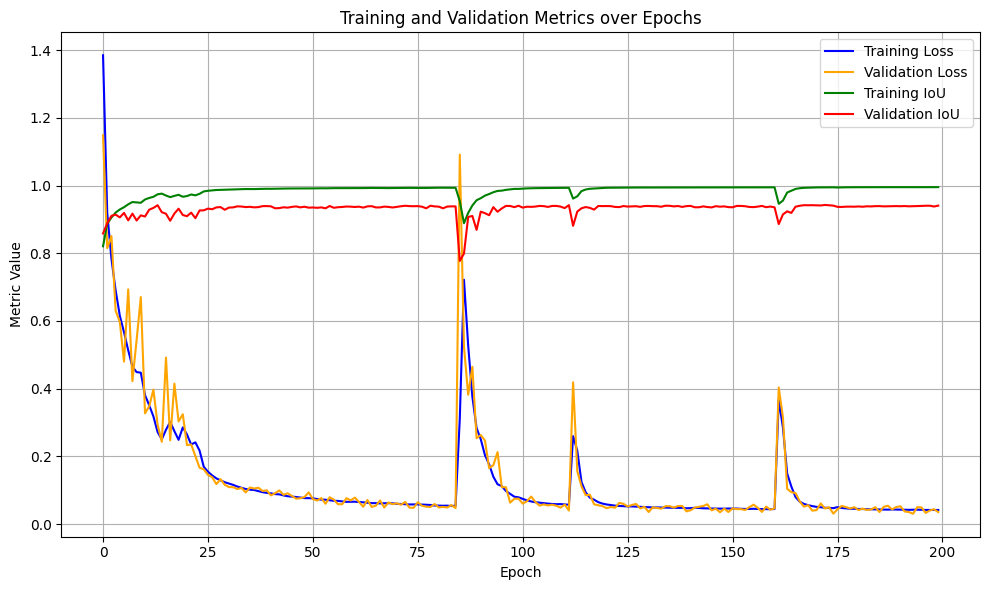

In [ ]:
# Step 17: Visualize Training and Validation Metrics
plt.figure(figsize=(10, 6))

# Plotting Training Loss
plt.plot(train_loss_hist, label='Training Loss', color='blue')

# Plotting Validation Loss
plt.plot(val_loss_hist, label='Validation Loss', color='orange')

plt.plot(train_iou_hist, label='Training IoU', color='green')

# Plotting Validation IoU
plt.plot(val_iou_hist, label='Validation IoU', color='red')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training and Validation Metrics over Epochs')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Step 18: Save Model Weights
torch.save(model.cpu().state_dict(), model_path)